In [76]:
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
from jax import random
from flax.training import train_state
from jax.experimental.ode import odeint

import time

# RELOADING MODULES
import importlib
import neural_net_pyomo
import matplotlib.pyplot as plt

importlib.reload(neural_net_pyomo)
NeuralODEPyomo = neural_net_pyomo.NeuralODEPyomo

# UTILS DIRECTORY
import sys
import os
collocation2_path = os.path.abspath(os.path.join('..', 'utils'))

if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative

import non_parametric_collocation 
importlib.reload(non_parametric_collocation)
collocate_data = non_parametric_collocation.collocate_data

import data_generation 
importlib.reload(data_generation)
generate_ode_data = data_generation.generate_ode_data

## `Toy dataset check`

In [61]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.1
ode_type, params = "sinusoidal_oscillator", {"A": 0.25}
start_time, end_time = 0, 10
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights = compute_weights(t)
D = np.array(lagrange_derivative(t, weights))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test, y_test, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, 20, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)

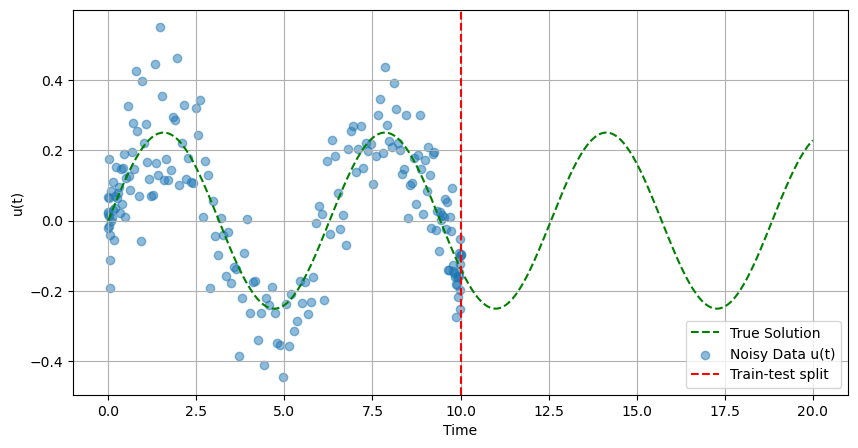

In [62]:
plt.figure(figsize=(10, 5))
plt.plot(t_test, y_test, 'g--', label='True Solution')
plt.scatter(t, y_noisy.T, label='Noisy Data u(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [63]:
u = np.atleast_2d(y_noisy).T
r, c = u.shape
print(f"r : {r}; c : {c}")

u_estimated = np.atleast_2d(estimated_solution).T
r, c = u_estimated.shape
print(f"r : {r}; c : {c}")

r : 200; c : 1
r : 200; c : 1


In [64]:
layer_widths = [2, 20, 20, 1]

# solver.options['print_level'] = 5
params = {"tol":1e-7, "print_level": 5}

start_timer_build = time.time()
ode_model = NeuralODEPyomo(u, t, D, layer_widths, max_iter = 500, act_func = "tanh", y_init = u_estimated, extra_input = t, params = params) # , extra_input = t_ho
ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()
u_model = ode_model.extract_solution().T

Ipopt 3.14.16: max_iter=500
print_level=5
tol=1e-07
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   139499
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   132970

Total number of variables............................:      701
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      200
                     variables with only upper bounds:        0
Total number of 

Train MAE: 0.013735573459254176
Test MAE: 3.5751784460082288


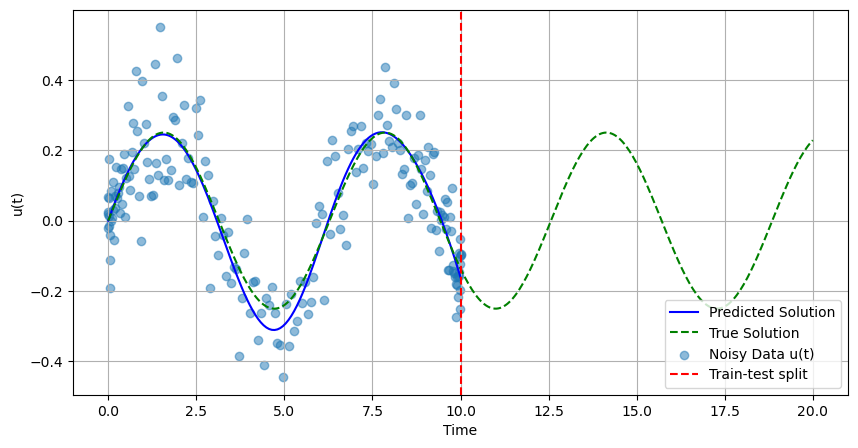

In [67]:
def system_dynamics(y, t):
    input = jnp.array([y[0], t])
    du_dt = ode_model.predict(input)
    return jnp.array([du_dt])

initial_conditions = jnp.array([0.0]) 
y_pred_train = odeint(system_dynamics, initial_conditions, t)    
mae_train = jnp.mean(jnp.abs(y_pred_train - y))
print (f"Train MAE: {mae_train}")

y1 = y_pred_train[-1, :]
y_pred_test = odeint(system_dynamics, y1, t_test[N-1:])
mae_test = jnp.mean(jnp.abs(y_pred_test - y_test[N-1:]))
print (f"Test MAE: {mae_test}")

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(10, 5))
plt.plot(t, y_pred_train, 'b', label='Predicted Solution')
plt.plot(t_test[N-1:], y_pred_test, 'b--', label='Predicted Solution', omega = 0.5)

#plt.plot(t_ho, v_model, 'r', label='Predicted Solution')
plt.plot(t_test, y_test, 'g--', label='True Solution')

plt.scatter(t, y_noisy.T, label='Noisy Data u(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [252]:
u = np.atleast_2d(y_noisy_ho[:,0]).T
r, c = u.shape
print(f"r : {r}; c : {c}")

u_estimated = estimated_solution_ho[0]
u_estimated = np.atleast_2d(u_estimated).T
r, c = u_estimated.shape
print(f"r : {r}; c : {c}")

r : 200; c : 1
r : 200; c : 1


In [77]:
layer_widths = [1, 40, 40, 1]

# solver.options['print_level'] = 5
params = {"tol":1e-8, "print_level": 5, "mu_strategy": "adaptive", "constr_viol_tol":1e-8}

start_timer_build = time.time()
ode_model = NeuralODEPyomo(u, t, D, layer_widths, penalty_lambda = 0.001, max_iter = 500, act_func = "tanh", y_init = u_estimated, params = params) # , extra_input = t_ho
ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()
u_model = ode_model.extract_solution().T

Ipopt 3.14.16: max_iter=500
halt_on_ampl_error=yes
tol=1e-08
print_level=5
mu_strategy=adaptive
constr_viol_tol=1e-08


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   390239
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   524160

Total number of variables............................:     1961
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      200
                     variables with o

Train MAE: 0.2088412672987119
Test MAE: 0.17417146233421424


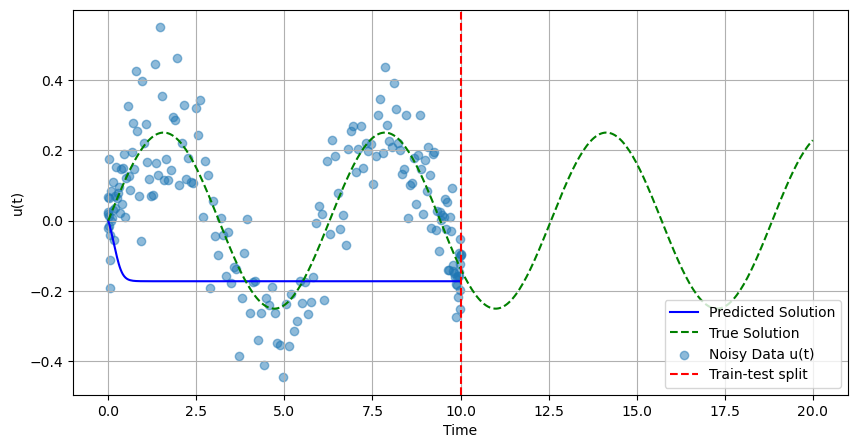

In [78]:
def system_dynamics(y, t):
    input = jnp.array([y[0]])
    du_dt = ode_model.predict(input)
    return jnp.array([du_dt])

initial_conditions = jnp.array([0.0]) 
y_pred_train = odeint(system_dynamics, initial_conditions, t)    
mae_train = jnp.mean(jnp.abs(y_pred_train - y))
print (f"Train MAE: {mae_train}")

y1 = y_pred_train[-1, :]
y_pred_test = odeint(system_dynamics, y1, t_test[N-1:])
mae_test = jnp.mean(jnp.abs(y_pred_test - y_test[N-1:]))
print (f"Test MAE: {mae_test}")

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(10, 5))
plt.plot(t, y_pred_train, 'b', label='Predicted Solution')
#plt.plot(t_test[N-1:], y_pred_test, 'b', label='Predicted Solution')

#plt.plot(t_ho, v_model, 'r', label='Predicted Solution')
plt.plot(t_test, y_test, 'g--', label='True Solution')

plt.scatter(t, y_noisy.T, label='Noisy Data u(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [350]:
importlib.reload(neural_net_pyomo)
NeuralODEPyomo = neural_net_pyomo.NeuralODEPyomo

In [368]:
layer_widths = [1, 100, 100, 1]

start_timer_build = time.time()
ode_model = NeuralODEPyomo(u, t_ho, D_ho, layer_widths, max_iter = 100, act_func = "tanh", y_init = u_estimated, penalty_lambda = 0.01) # , extra_input = t_ho
ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()
u_model = ode_model.extract_solution().T

Ipopt 3.14.16: max_iter=1000
print_level=5
tol=1e-08
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    67859
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    31440

Total number of variables............................:      341
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      200
                     variables with only upper bounds:        0
Total number of

In [365]:
def system_dynamics(y, t):
    input = jnp.array([y[0], t])
    du_dt = ode_model.predict(input)
    return du_dt

initial_conditions = jnp.array([0.0]) 
y_pred_train = odeint(system_dynamics, initial_conditions, t_ho)    
mae_train = jnp.mean(jnp.abs(y_pred_train - y_ho))
print (f"Train MAE: {mae_train}")

y1 = y_pred_train[-1, :]
y_pred_test = odeint(system_dynamics, y1, t_test_ho[N-1:])
mae_test = jnp.mean(jnp.abs(y_pred_test - y_test_ho[N-1:]))
print (f"Test MAE: {mae_test}")

Train MAE: 0.5896108140796751
Test MAE: 5.218175324295857


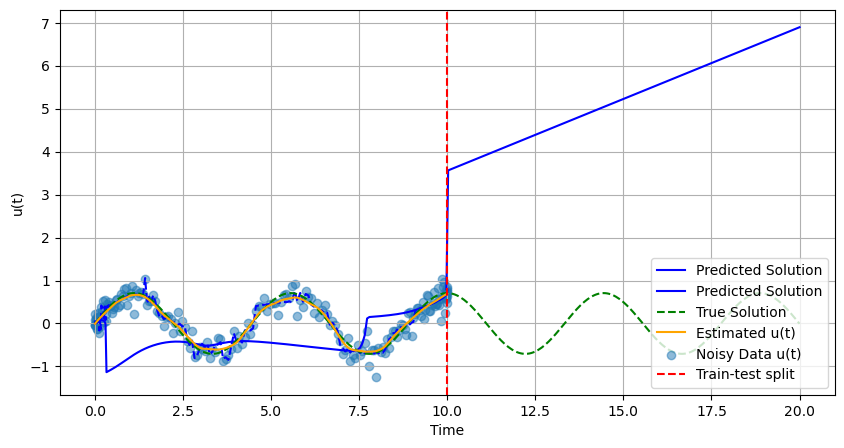

In [366]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(10, 5))
plt.plot(t_test_ho[N-1:], y_pred_test, 'b', label='Predicted Solution')
plt.plot(t_ho, y_pred_train, 'b', label='Predicted Solution')
plt.plot(t_ho, u_model.T, 'b--')

plt.plot(t_test_ho, y_test_ho.T[0], 'g--', label='True Solution')
plt.plot(t_ho, u_estimated, label='Estimated u(t)', color = 'orange')
plt.scatter(t_ho, u, label='Noisy Data u(t)', alpha = 0.5)

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

## `Load Real Life Data`

In [98]:
import non_parametric_collocation 
importlib.reload(non_parametric_collocation)
collocate_data = non_parametric_collocation.collocate_data

In [94]:
t_train = np.squeeze(np.array(pd.read_csv('../data/daily_climate/train/X_train.csv'), dtype=np.float64)) # x is timepoints t
y_train = np.array(pd.read_csv('../data/daily_climate/train/y_train.csv'))

t_test = np.squeeze(np.array(pd.read_csv('../data/daily_climate/test/X_test.csv'), dtype=np.float64))
y_test = np.array(pd.read_csv('../data/daily_climate/test/y_test.csv')) # y is the mean temperature

In [76]:
print(y_train.shape)
print(t_train.shape)

(788, 1)
(788,)


In [25]:
weights = compute_weights(t_train)
D = np.array(lagrange_derivative(t_train, weights))

In [103]:
estimated_derivative, estimated_solution = collocate_data(y_train, t_train, 'EpanechnikovKernel', bandwidth=15)

Data transposed to match expected dimensions.


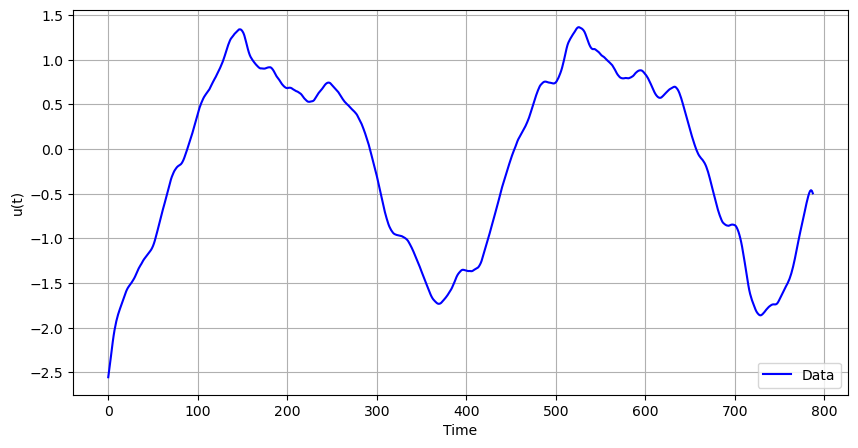

In [106]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(10, 5))
plt.plot(t_train, estimated_solution, 'b', label='Data')
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [110]:
y_train.shape

(788, 1)

In [108]:
layer_widths = [1, 10, 1]

start_timer_build = time.time()
ode_model = NeuralODEPyomo(y_train, t_train, D, layer_widths, max_iter = 1000, act_func = "tanh", y_init = estimated_solution, w_init_method = 'xavier') 
ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()

u_model, v_model = ode_model.extract_solution()

def system_dynamics(y, t):
    # input = jnp.array([y[0], y[1]])
    dy_dt = ode_model.predict(y)
    return dy_dt

ERROR: Rule failed when initializing variable for Var y with index None:
IndexError: too many indices for array: array is 1-dimensional, but 2 were
indexed
ERROR: Constructing component 'y' from data=None failed:
        IndexError: too many indices for array: array is 1-dimensional, but 2
        were indexed


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed